In [24]:
import os

import pandas as pd
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
df = pd.read_csv('./preprocessed_apartment.csv')
df.head()

,city,district,dong,apartment,m2,price,floor,pre_m2,moving_date,num_people,people_by_m2,price_by_m2,price_by_pre_m2,year,month
0,8,1,1156,1504,196.21,450000.0,13.0,211.23,1976.06,480.0,120.0,7582.0,7043.0,2018,12
1,8,1,1706,4942,202.58,450000.0,5.0,252.31,2010.07,19.0,1.0,7343.0,5896.0,2018,12
2,8,1,1156,9746,139.83,320000.0,7.0,165.29,1982.04,1924.0,168.0,7565.0,6400.0,2018,12
3,8,1,393,15322,191.04,315000.0,2.0,219.22,1983.12,1204.0,84.0,5451.0,4750.0,2018,12
4,8,1,1156,1509,144.20,304000.0,10.0,158.68,1979.05,560.0,168.0,6969.0,6333.0,2018,12


In [3]:
df.shape

(6174900, 15)

In [4]:
# df_down1 = df.sample(n=600000)
# print(df_down1.shape)
# df_down1.head()

In [5]:
# df_down2 = df.sample(n=15000)
# print(df_down2.shape)
# df_down2.head()

In [6]:
# df_down3 = df.sample(n=1000)
# print(df_down3.shape)
# df_down3.head()

In [7]:
# df_down4 = df.sample(n=100)
# print(df_down4.shape)
# df_down4.head()

In [8]:
y = df['price']
del df['price']

In [9]:
x_train, x_test,y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=0)

In [10]:
lightgbm = lgb.LGBMRegressor(random_state=0)

In [11]:
kfold = KFold(n_splits=5, random_state=0).get_n_splits(x_train.values)
cross_val_score(lightgbm, x_train.values, y_train)

C:\ProgramData\Anaconda3\envs\p36\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


array([0.99727589, 0.99734241, 0.99746746])

In [12]:
lightgbm.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
modelPred = lightgbm.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

1162.6522626090643

In [14]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 25000.000, 예상가격: 24647.146
실제가격: 20900.000, 예상가격: 20523.162
실제가격: 35700.000, 예상가격: 36001.417
실제가격: 29250.000, 예상가격: 29769.758
실제가격: 5800.000, 예상가격: 5868.432
실제가격: 9500.000, 예상가격: 9083.648
실제가격: 15400.000, 예상가격: 15092.925
실제가격: 6300.000, 예상가격: 6388.948
실제가격: 20100.000, 예상가격: 20254.150
실제가격: 41500.000, 예상가격: 40657.368


In [15]:
model = Sequential()
model.add(Dense(140, input_dim=14, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=['accuracy'])

In [17]:
# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
    
# 모델 저장 조건 설정
modelpath = MODEL_DIR + '{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# loss는 train loss고 val_loss는 validation loss임 / acc도 마찬가지

In [18]:
history = model.fit(x_train, y_train, validation_split=0.4, epochs=100, batch_size=1000, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 2593458 samples, validate on 1728972 samples
Epoch 1/100
2593458/2593458 [==============================] - 24s 9us/step - loss: 70214569.7235 - acc: 2.4716e-04 - val_loss: 5303052.1472 - val_acc: 3.7652e-04

Epoch 00001: val_loss improved from inf to 5303052.14716, saving model to ./model/01-5303052.1472.hdf5
Epoch 2/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 2503476.8177 - acc: 6.4200e-04 - val_loss: 1053355.2094 - val_acc: 9.9076e-04

Epoch 00002: val_loss improved from 5303052.14716 to 1053355.20940, saving model to ./model/02-1053355.2094.hdf5
Epoch 3/100
2593458/2593458 [==============================] - 24s 9us/step - loss: 892790.1534 - acc: 8.9494e-04 - val_loss: 512445.0450 - val_acc: 0.0013

Epoch 00003: val_loss improved from 1053355.20940 to 512445.04501, saving model to ./model/03-512445.0450.hdf5
Epoch 4/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 628

2593458/2593458 [==============================] - 24s 9us/step - loss: 149133.8527 - acc: 0.0028 - val_loss: 50253.2008 - val_acc: 0.0037

Epoch 00034: val_loss did not improve from 47815.34383
Epoch 35/100
2593458/2593458 [==============================] - 24s 9us/step - loss: 99993.8031 - acc: 0.0029 - val_loss: 35992.3787 - val_acc: 0.0042

Epoch 00035: val_loss improved from 47815.34383 to 35992.37875, saving model to ./model/35-35992.3787.hdf5
Epoch 36/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 89847.1451 - acc: 0.0028 - val_loss: 39328.1917 - val_acc: 0.0038

Epoch 00036: val_loss did not improve from 35992.37875
Epoch 37/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 94647.6423 - acc: 0.0027 - val_loss: 74939.6523 - val_acc: 0.0027

Epoch 00037: val_loss did not improve from 35992.37875
Epoch 38/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 120377.2519 - acc: 0.0029 - val_loss: 42807.056

2593458/2593458 [==============================] - 23s 9us/step - loss: 71699.8745 - acc: 0.0037 - val_loss: 24426.7846 - val_acc: 0.0050

Epoch 00072: val_loss did not improve from 23673.18486
Epoch 73/100
2593458/2593458 [==============================] - 22s 9us/step - loss: 58878.5299 - acc: 0.0037 - val_loss: 172686.8473 - val_acc: 0.0025

Epoch 00073: val_loss did not improve from 23673.18486
Epoch 74/100
2593458/2593458 [==============================] - 22s 8us/step - loss: 54495.4048 - acc: 0.0037 - val_loss: 24790.4614 - val_acc: 0.0040

Epoch 00074: val_loss did not improve from 23673.18486
Epoch 75/100
2593458/2593458 [==============================] - 22s 9us/step - loss: 80332.8260 - acc: 0.0039 - val_loss: 40807.9193 - val_acc: 0.0014

Epoch 00075: val_loss did not improve from 23673.18486
Epoch 76/100
2593458/2593458 [==============================] - 23s 9us/step - loss: 48915.0231 - acc: 0.0038 - val_loss: 88644.6148 - val_acc: 0.0028

Epoch 00076: val_loss did not im

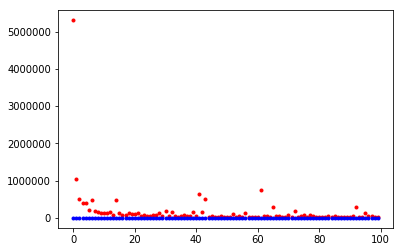

In [19]:
# y_vloss에 테스트셋으로 실험 결과의 오차 값을 저장
y_vloss = history.history['val_loss']

# y_acc에 학습셋으로 측정한 정확도의 값을 저장
y_acc = history.history['acc']

# x값을 지정하고 정확도를 파랑색으로, 오차를 빨강색으로 표시
x_len = np.arange(len(y_acc))
plt.plot(x_len, y_vloss, "o", c="red", markersize=3)
plt.plot(x_len, y_acc, "o", c="blue", markersize=3)

plt.show()

In [20]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

168.59611300710216

In [21]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 25000.000, 예상가격: 25024.381
실제가격: 20900.000, 예상가격: 20915.410
실제가격: 35700.000, 예상가격: 35714.250
실제가격: 29250.000, 예상가격: 29223.035
실제가격: 5800.000, 예상가격: 5766.654
실제가격: 9500.000, 예상가격: 9527.574
실제가격: 15400.000, 예상가격: 15428.654
실제가격: 6300.000, 예상가격: 6289.704
실제가격: 20100.000, 예상가격: 20101.650
실제가격: 41500.000, 예상가격: 41587.426


In [25]:
model = load_model('./model/95-17173.8919.hdf5')

In [26]:
modelPred = model.predict(x_test)
RMSE = sqrt(mean_squared_error(y_test, modelPred))
RMSE

132.54796960104287

In [27]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, prediction))

실제가격: 25000.000, 예상가격: 25027.246
실제가격: 20900.000, 예상가격: 21001.854
실제가격: 35700.000, 예상가격: 35735.145
실제가격: 29250.000, 예상가격: 29460.674
실제가격: 5800.000, 예상가격: 5803.538
실제가격: 9500.000, 예상가격: 9549.287
실제가격: 15400.000, 예상가격: 15469.050
실제가격: 6300.000, 예상가격: 6315.014
실제가격: 20100.000, 예상가격: 20108.818
실제가격: 41500.000, 예상가격: 41582.715


In [33]:
Y_prediction = modelPred.flatten()
for i in range(10):
    label = y_test.values[i]
    prediction = Y_prediction[i]
    print("실제가격: {:.3f}, 예상가격: {:.3f}".format(label, round(prediction)))

실제가격: 25000.000, 예상가격: 25027.000
실제가격: 20900.000, 예상가격: 21002.000
실제가격: 35700.000, 예상가격: 35735.000
실제가격: 29250.000, 예상가격: 29461.000
실제가격: 5800.000, 예상가격: 5804.000
실제가격: 9500.000, 예상가격: 9549.000
실제가격: 15400.000, 예상가격: 15469.000
실제가격: 6300.000, 예상가격: 6315.000
실제가격: 20100.000, 예상가격: 20109.000
실제가격: 41500.000, 예상가격: 41583.000
